# Initialization


In [1]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes import Axes

from cb25d.compare_gamma_original import run_gamma_comparison_original
from cb25d.notebook import init, savefig
from cb25d.simulation_impl_original import (
    SimulationImplOriginal,
    generate_initial_conditions,
)

init()

pygame-ce 2.5.6 (SDL 2.32.10, Python 3.13.9)


# Gamma value comparison


## Initialization


In [2]:
p_base = Path("results/original/gamma")

## Computation


In [7]:
def compute(k: int):
    att_vals = np.arange(0, 0.6 + (step := 0.05), step)
    ali_vals = np.arange(0, 1.2 + (step := 0.1), step)
    statistics = run_gamma_comparison_original(
        seed=0,
        att_vals=att_vals,
        ali_vals=ali_vals,
        create_initial_state=lambda att, ali, seed: SimulationImplOriginal(
            c_eta=0.8,
            c_gamma_ali=ali,
            c_gamma_att=att,
            c_gamma_rand=0.2,
            c_k=k,
            c_l_ali=3,
            c_tau_0=0.8,
            **generate_initial_conditions(
                seed=seed,
                n=100,
                l_att=3,
            ),
        ),
        runs_per_config=20,
        steps_per_run=2000 * 100,
    )

    p = p_base / f"k={k}"
    p.mkdir(parents=True, exist_ok=True)
    np.save(p / "att.npy", att_vals)
    np.save(p / "ali.npy", ali_vals)
    np.save(p / "statistics.npy", statistics)

In [ ]:
compute(k=1)

In [ ]:
compute(k=2)

## Plot


In [3]:
def load(k: int):
    p = p_base / f"k={k}"
    return (
        np.load(p / "att.npy"),
        np.load(p / "ali.npy"),
        np.load(p / "statistics.npy"),
    )


k1 = load(k=1)
k2 = load(k=2)
assert np.array_equal(k1[:2], k2[:2])
att_vals, ali_vals = k1[:2]
statistics = np.array([k1[2], k2[2]])

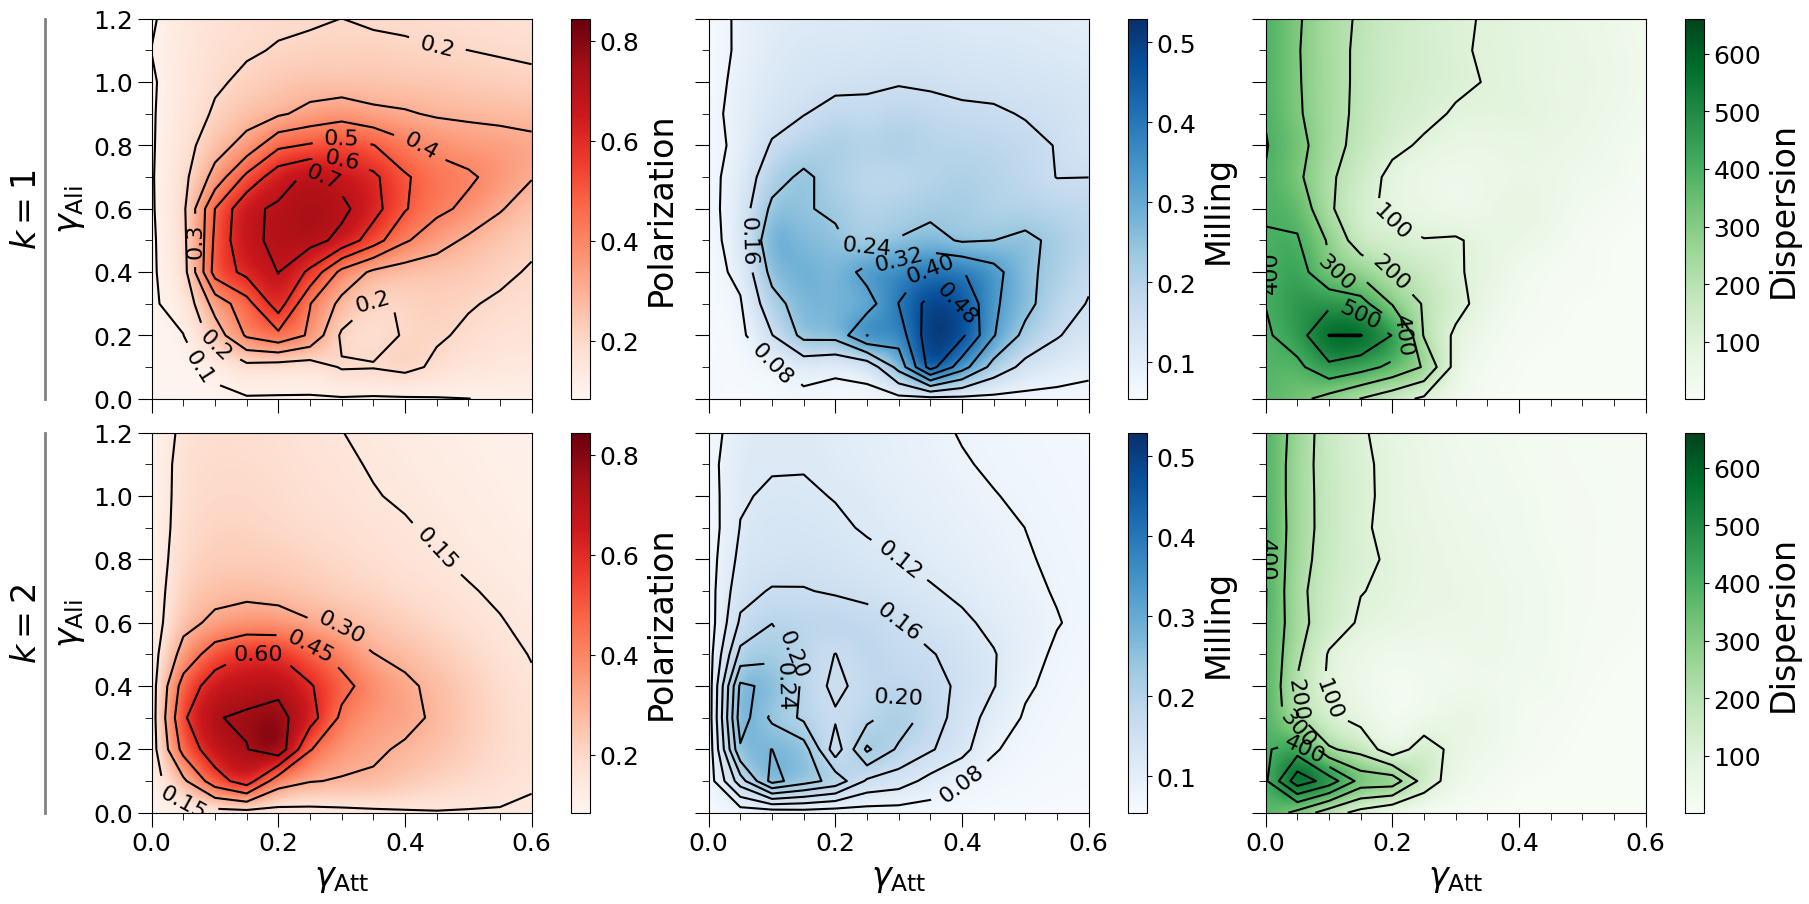

In [ ]:
fig, axd = plt.subplot_mosaic(
    """
    lpmd
    LPMD
    """,
    width_ratios=[0.05, 1, 1, 1],
    figsize=(18, 10),
    layout="compressed",
)

fontsize_big = 24
fontsize_label = 24
fontsize_tick = 18
fontsize_contour = 16
vmin = np.min(statistics, axis=(0, 1, 2))
vmax = np.max(statistics, axis=(0, 1, 2))


def plot_single(
    ax: Axes,
    k: int,
    stat_i: int,
    cmap: str,
    cbar_label: str,
    set_xlabel: bool,
    set_ylabel: bool,
):
    data = statistics[k - 1, :, :, stat_i].T

    # Background
    dx = att_vals[1] - att_vals[0]  # Used to offset the image
    dy = ali_vals[1] - ali_vals[0]  # by half a square
    im = ax.imshow(
        data,
        cmap=cmap,
        aspect="auto",
        interpolation="quadric",
        vmin=vmin[stat_i],
        vmax=vmax[stat_i],
        origin="lower",
        extent=(-dx / 2, att_vals.max() + dx / 2, -dy / 2, ali_vals.max() + dy / 2),
    )
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=fontsize_tick)
    cbar.set_label(cbar_label, fontsize=fontsize_label)

    # Contour
    cntr = ax.contour(
        att_vals,
        ali_vals,
        data,
        vmin=vmin[stat_i],
        vmax=vmax[stat_i],
        levels=6,
        colors="k",
    )
    ax.clabel(cntr, cntr.levels, fontsize=fontsize_contour)  # type: ignore

    # Axis setup
    if set_xlabel:
        ax.set_xlabel(r"$\gamma_\text{Att}$", fontsize=fontsize_label)
    else:
        plt.setp(ax.get_xticklabels(), visible=False)
    if set_ylabel:
        ax.set_ylabel(r"$\gamma_\text{Ali}$", fontsize=fontsize_label)
    else:
        plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_xticks(att_vals, minor=True)
    ax.set_yticks(ali_vals, minor=True)
    ax.set_xlim(att_vals[0], att_vals[-1])
    ax.set_ylim(ali_vals[0], ali_vals[-1])
    ax.set_box_aspect(1)
    ax.tick_params(length=10, labelsize=fontsize_tick)
    ax.tick_params(which="minor", length=5)


def plot_row(axs: str, k: int, set_xlabel: bool):
    # Use the ax as a canvas to draw a label and a line
    ax = axd[axs[0]]
    ax.axis(False)
    ax.plot(
        [1, 1],
        [0, 1],
        transform=ax.transAxes,
        color="gray",
        linewidth=2,
        clip_on=False,
    )
    ax.text(
        0,
        0.5,
        f"$k={k}$",
        transform=ax.transAxes,
        rotation=90,
        va="center",
        ha="center",
        fontsize=fontsize_big,
    )

    # Draw the actual plots
    axd[axs[2]].sharey(axd[axs[1]])
    axd[axs[3]].sharey(axd[axs[1]])
    plot_single(axd[axs[1]], k, 1, "Reds", "Polarization", set_xlabel, True)
    plot_single(axd[axs[2]], k, 2, "Blues", "Milling", set_xlabel, False)
    plot_single(axd[axs[3]], k, 0, "Greens", "Dispersion", set_xlabel, False)


# Sharex for each column that isn't the label
axd["P"].sharex(axd["p"])
axd["M"].sharex(axd["m"])
axd["D"].sharex(axd["d"])

plot_row("lpmd", 1, False)
plot_row("LPMD", 2, True)

savefig(fig, "fig/original/gamma/combined.pdf")